In [1]:
# Copied from https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions
# Modified the code to make it more generic 
# Included "hard coded data" for Turkey and Republic of Ireland (ROI)

In [2]:
import pandas as pd
import numpy as np
from datetime import datetime,timedelta
from sklearn.metrics import mean_squared_error
from scipy.optimize import curve_fit
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
%matplotlib inline

# Curve Fitting functions

## 1 - Logistic regression

In [3]:
# The logistic model describes an infection growth that is going to stop in the future, 

In [4]:
# a refers to the infection speed
# b is the day with the maximum infections occurred
# c is the total number of recorded infected people at the infection’s end
def logistic_model(x,a,b,c):
    return c/(1+np.exp(-(x-b)/a))



In [5]:
def calculate_sol_days(x, logistic_model_func, a_lr, b_lr, c_lr):
    # The expected infection end can be calculated as that particular day at which the cumulative 
    # infected people count is equal to the c parameter rounded to the nearest integer.
    sol_date = int(fsolve(lambda x : logistic_model_func(x, a_lr, b_lr, c_lr) - int(c_lr), b_lr))
    return sol_date

In [6]:
def print_sol_date(x, logistic_model_func, a_lr, b_lr, c_lr):
    # The expected infection end can be calculated as that particular day at which the cumulative 
    # infected people count is equal to the c parameter rounded to the nearest integer.
    sol_days = calculate_sol_days(x, logistic_model, a_lr,b_lr,c_lr)
    print("Days since new year: {}".format(sol_days)) 
    # check from https://asd.gsfc.nasa.gov/Craig.Markwardt/doy2020.html
    sol_date = datetime(2020,1,1) + timedelta(days=sol_days-1)
    print(sol_date.strftime("%d %B %Y"))

## 2 - Exponential growth

In [7]:
# The exponential model describes an unstoppable infection

In [8]:
def exponential_model(x,a,b,c):
    return a*np.exp(b*(x-c))

## 3 - Generic code for curve fitting

In [9]:
def fit_curve(model_function, x, y, p0, population):
    # methods: [lm, trf, dogbox]
    # Method 'lm' only works for unconstrained problems. Use 'trf' or 'dogbox' instead.
    fit = curve_fit(model_function, x, y, p0=p0, maxfev=5000, method="trf", 
                    bounds=(0, [np.inf, np.inf, population * 0.20]))
    #fit = curve_fit(model_function, x, y, p0=p0, maxfev=5000, method="lm")
    # print("fit_result: {}".format(fit))
    a , b, c = fit[0]
    # standard error 
    errors = [np.sqrt(fit[1][i][i]) for i in [0,1,2]]
    return a , b, c, errors

##  4 - Plot & evaluate

In [10]:
# TODO convert func, abc_tuple into struct and pass array of that struct
def plot_curves(x, y, logistic_model_func, abc_tuple_lr, exponential_model_func, abc_tuple_exp):
    sol = calculate_sol_days(x, logistic_model_func, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2])
    pred_x = list(range(max(x),sol))
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)
    # Real data
    plt.scatter(x,y,label="Real data",color="red")
    
    # Predicted logistic curve
    plt.plot(x+pred_x, 
             [logistic_model_func(i, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2]) for i in x+pred_x], 
             label="Logistic model" )
    # Predicted exponential curve
    plt.plot(x+pred_x, 
             [exponential_model_func(i, abc_tuple_exp[0] , abc_tuple_exp[1], abc_tuple_exp[2]) for i in x+pred_x], 
             label="Exponential model" )
    plt.legend()
    plt.xlabel("Days since 1 January 2020")
    plt.ylabel("Total number of infected people")
    plt.ylim((min(y)*0.9,abc_tuple_lr[2]*1.1))
    plt.show()
    

def plot_curves_countries(logistic_model_func, country_2_abc_tuple_lr, country_2_xy):
    plt.rcParams['figure.figsize'] = [7, 7]
    plt.rc('font', size=14)
    
    for country, abc_tuple_lr in country_2_abc_tuple_lr.items():
        x = country_2_xy[country][0]
        y = country_2_xy[country][1]
        
        sol = calculate_sol_days(x, logistic_model_func, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2])
        pred_x = list(range(max(x),sol))
    
        # Real data
        plt.scatter(x,y, color="red")
    
        # Predicted logistic curve
        plt.plot(x+pred_x, 
                 [logistic_model_func(i, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2]) for i in x+pred_x], 
                 label="Logistic model({})".format(country))
        
    plt.legend()
    plt.xlabel("Days since 1 January 2020")
    plt.ylabel("Total number of infected people")
    plt.show()

In [11]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.
def calculate_mse(x, y, logistic_model_func, abc_tuple_lr, exponential_model_func, abc_tuple_exp):
    y_pred_logistic = [logistic_model_func(i, abc_tuple_lr[0] , abc_tuple_lr[1], abc_tuple_lr[2]) for i in x]
    y_pred_exp =  [exponential_model_func(i, abc_tuple_exp[0] , abc_tuple_exp[1], abc_tuple_exp[2]) for i in x]
    mse_lr = mean_squared_error(y,y_pred_logistic)
    mse_exp = mean_squared_error(y,y_pred_exp)
    return mse_lr, mse_exp

# Execute logistic regression & exponential growth

In [12]:
# Current date:
today = datetime.now()
print(today.strftime("%d %B %Y"))

02 April 2020


In [13]:
# generic parameters
days_since_start = 45 # predicted that after days_since_start maximum number of infections occurs
percentage_of_population = 0.03 # percentage_of_population predicted to be infected at the infection’s end
p0_a = 2

In [14]:
# To be used later
country_2_abc_tuple_lr = {}
country_2_xy = {}

## 1 - Data on Italy

### 1.1 - Load data

In [15]:
url = "https://raw.githubusercontent.com/pcm-dpc/COVID-19/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv"
df = pd.read_csv(url)

In [16]:
df.tail()

,data,stato,ricoverati_con_sintomi,terapia_intensiva,totale_ospedalizzati,isolamento_domiciliare,totale_positivi,variazione_totale_positivi,nuovi_positivi,dimessi_guariti,deceduti,totale_casi,tamponi,note_it,note_en
34,2020-03-29T17:00:00,ITA,27386,3906,31292,42588,73880,3815,5217,13030,10779,97689,454030,pd-IT-0009,pd-EN-0009
35,2020-03-30T17:00:00,ITA,27795,3981,31776,43752,75528,1648,4050,14620,11591,101739,477359,NaN,NaN
36,2020-03-31T17:00:00,ITA,28192,4023,32215,45420,77635,2107,4053,15729,12428,105792,506968,NaN,NaN
37,2020-04-01T17:00:00,ITA,28403,4035,32438,48134,80572,2937,4782,16847,13155,110574,541423,NaN,NaN
38,2020-04-02T17:00:00,ITA,28540,4053,32593,50456,83049,2477,4668,18278,13915,115242,581232,NaN,NaN


In [17]:
df = df.loc[:,['data','totale_casi']]
FMT = '%Y-%m-%dT%H:%M:%S'
date = df['data']
df['data'] = date.map(lambda x : (datetime.strptime(x, FMT) - datetime.strptime("2020-01-01T00:00:00", FMT)).days  )

In [18]:
df.tail()

,data,totale_casi
34,88,97689
35,89,101739
36,90,105792
37,91,110574
38,92,115242


In [19]:
# Data
x = list(df.iloc[:,0])
y = list(df.iloc[:,1])

In [20]:
# p0: Initial guess for the parameters (length N)
population = 60.48 * 1e6# 60.48 million
start_date = 54 # 54th day of the year


p0_b = days_since_start + start_date # # i.e. peak after days_since_start days
p0_c = percentage_of_population * population # percentage_of_population of the population 
p0_lr = [p0_a, p0_b, p0_c ] 
p0_exp = [1,1,1]

### 1.2 - Execute Logistic Regression

In [21]:
# Logistic Regression
a_lr , b_lr, c_lr, errors_lr = fit_curve(logistic_model, x, y, p0=p0_lr, population=population)
print("a_lr:{} , b_lr:{}, c_lr:{} ".format(a_lr , b_lr, c_lr))
print("errors_lr: {}".format(errors_lr))


a_lr:5.577308982717077 , b_lr:82.59299605526213, c_lr:134639.42594302935 
errors_lr: [0.0689764192014753, 0.14606952134473325, 1384.5155119969204]


In [22]:
# The expected infection end can be calculated as that particular day at which the cumulative 
# infected people count is equal to the c parameter rounded to the nearest integer.
print_sol_date(x, logistic_model, a_lr, b_lr, c_lr)

Days since new year: 153
01 June 2020


### 1.3 - Execute Exponential Growth

In [23]:
# Exponential Growth
a_exp , b_exp, c_exp, errors_exp = fit_curve(exponential_model, x, y, p0=p0_exp, population=population)
print("a_exp:{} , b_exp:{}, c_exp:{} ".format(a_exp , b_exp, c_exp))
print("errors_exp: {}".format(errors_exp))

a_exp:49.939537629597694 , b_exp:0.08786936795057604, c_exp:2.374295522690848 
errors_exp: [8151144.675707152, 0.004098955897092113, 1857533.6202927688]


### 1.4 - Plot

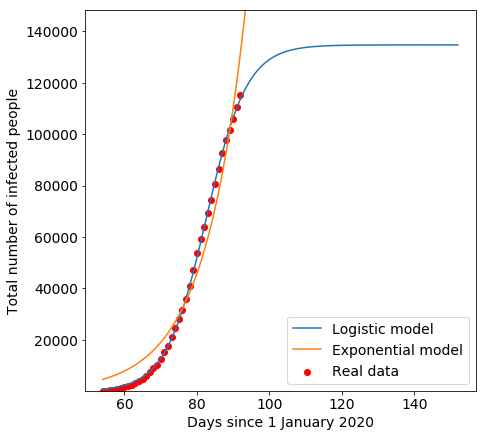

In [24]:
plot_curves(x, y, logistic_model, (a_lr, b_lr, c_lr), exponential_model, (a_exp, b_exp, c_exp))

### 1.5 - Evaluate

In [25]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.

In [26]:
mse_lr, mse_exp = calculate_mse(x, y, logistic_model, (a_lr, b_lr, c_lr), 
                                exponential_model, (a_exp, b_exp, c_exp))
print("Logistic model MSE: {}".format(mse_lr))
print("Exponential model MSE: {}".format(mse_exp))

Logistic model MSE: 564461.9530799952
Exponential model MSE: 47931718.05227009


In [27]:
country = "Italy"
country_2_abc_tuple_lr[country] = (a_lr, b_lr, c_lr)
country_2_xy[country] = (x,y)

## 2 - Data on Republic of Ireland

### 2.1 - Load data

In [28]:
# TODO Get data automatically from some source
# Starts at Feb 29
population = 4.83 * 1e6 # 4.83 million
start_date = 60 # start_date-th day of the year

total_cases = [1, 1, 1, 2 , 6, 13, 18, 19, 21, 24, 34, 43, 70, 90, 129, 169, 223, 292, 366, 557, 683, 785, 906, 1125,
              1329, 1564, 1819, 2121, 2415, 2615, 2910, 3235, 3447, 3849 ]
dates = list(range(start_date, start_date + len(total_cases)))

In [29]:
# Data
x = dates
y = total_cases

In [30]:
# lr params
# a refers to the infection speed
# b is the day with the maximum infections occurred
# c is the total number of recorded infected people at the infection’s end

# p0: Initial guess for the parameters (length N)
p0_b = days_since_start + start_date # # i.e. peak after days_since_start days
p0_c = percentage_of_population * population # percentage_of_population of the population 
p0_lr = [p0_a, p0_b, p0_c] 
p0_exp = [1,1,1]

### 2.2 - Execute Logistic Regression

In [31]:
# Logistic Regression
a_lr , b_lr, c_lr, errors_lr = fit_curve(logistic_model, x, y, p0=p0_lr, population=population)
print("a_lr:{} , b_lr:{}, c_lr:{} ".format(a_lr , b_lr, c_lr))
print("errors_lr: {}".format(errors_lr))


a_lr:4.3015075714609265 , b_lr:88.51175250889605, c_lr:5068.049586941436 
errors_lr: [0.1052679131451584, 0.2867315111348668, 147.93178714062927]


In [32]:
# The expected infection end can be calculated as that particular day at which the cumulative 
# infected people count is equal to the c parameter rounded to the nearest integer.
print_sol_date(x, logistic_model, a_lr, b_lr, c_lr)

Days since new year: 138
17 May 2020


### 2.3 - Execute Exponential Growth

In [33]:
# Exponential Growth
a_exp , b_exp, c_exp, errors_exp = fit_curve(exponential_model, x, y, p0=p0_exp, population=population)
print("a_exp:{} , b_exp:{}, c_exp:{} ".format(a_exp , b_exp, c_exp))
print("errors_exp: {}".format(errors_exp))

a_exp:3.4932024707112808 , b_exp:0.13525648108065402, c_exp:40.62138771416069 
errors_exp: [11469119.813223343, 0.005343502742222773, 24274386.053363614]


### 2.4 - Plot

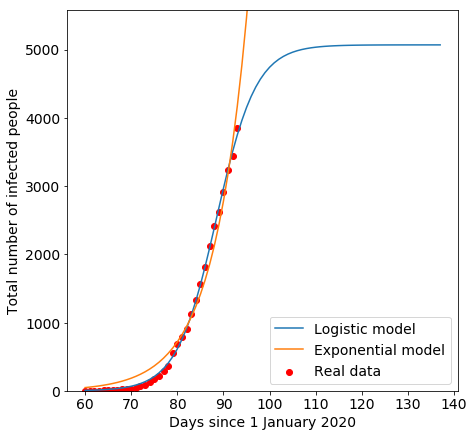

In [34]:
plot_curves(x, y, logistic_model, (a_lr, b_lr, c_lr), exponential_model, (a_exp, b_exp, c_exp))

### 2.5 - Evaluate

In [35]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.
mse_lr, mse_exp = calculate_mse(x, y, logistic_model, (a_lr, b_lr, c_lr), 
                                exponential_model, (a_exp, b_exp, c_exp))
print("Logistic model MSE: {}".format(mse_lr))
print("Exponential model MSE: {}".format(mse_exp))

Logistic model MSE: 1434.0479539414057
Exponential model MSE: 24016.75374249096


In [36]:
country = "RO_Ireland"
country_2_abc_tuple_lr[country] = (a_lr, b_lr, c_lr)
country_2_xy[country] = (x,y)

## 3 - Data on Turkey

### 3.1 - Load data

In [37]:
# TODO Get data automatically from some source
# Starts at March 11
population = 80.81 * 1e6 # 80.81 million
start_date = 71 # start_date-th day of the year

total_cases = [1, 2, 5, 6, 18, 47, 98, 191, 358, 670, 947, 1236, 1529, 1872, 2433, 3629, 5698, 7402, 9217, 10827, 
               13531, 15679, 18135]
dates = list(range(start_date, start_date + len(total_cases)))

In [38]:
# Data
x = dates
y = total_cases

In [39]:
# lr params
# a refers to the infection speed
# b is the day with the maximum infections occurred
# c is the total number of recorded infected people at the infection’s end

# p0: Initial guess for the parameters (length N)
p0_b = days_since_start + start_date # # i.e. peak after days_since_start days
p0_c = percentage_of_population * population # percentage_of_population of the population  
p0_lr = [p0_a, p0_b, p0_c] 
p0_exp = [1,1,1]

### 3.2 - Execute Logistic Regression

In [40]:
# Logistic Regression
a_lr , b_lr, c_lr, errors_lr = fit_curve(logistic_model, x, y, p0=p0_lr, population=population)
print("a_lr:{} , b_lr:{}, c_lr:{} ".format(a_lr , b_lr, c_lr))
print("errors_lr: {}".format(errors_lr))


a_lr:2.7716655792836344 , b_lr:90.76038843060151, c_lr:25973.54577150069 
errors_lr: [0.10387420537216896, 0.30754402689708915, 1305.1000833597927]


In [41]:
# The expected infection end can be calculated as that particular day at which the cumulative 
# infected people count is equal to the c parameter rounded to the nearest integer.
print_sol_date(x, logistic_model, a_lr, b_lr, c_lr)

Days since new year: 120
29 April 2020


### 3.3 - Execute Exponential Growth

In [42]:
# Exponential Growth
a_exp , b_exp, c_exp, errors_exp = fit_curve(exponential_model, x, y, p0=p0_exp, population=population)
print("a_exp:{} , b_exp:{}, c_exp:{} ".format(a_exp , b_exp, c_exp))
print("errors_exp: {}".format(errors_exp))

a_exp:2.6121301393232526 , b_exp:0.2188777320314243, c_exp:52.27116213619303 
errors_exp: [22602822.759860154, 0.011543670429821004, 39533595.59253679]


### 3.4 - Plot

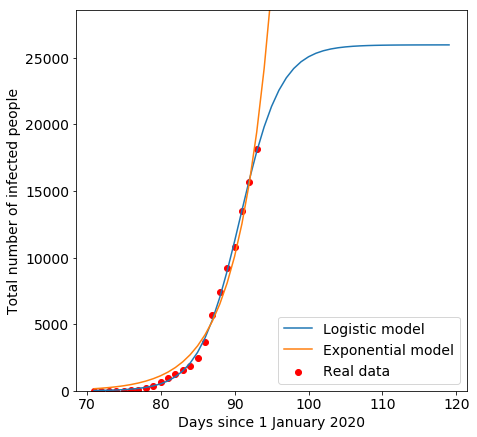

In [43]:
plot_curves(x, y, logistic_model, (a_lr, b_lr, c_lr), exponential_model, (a_exp, b_exp, c_exp))

### 3.5 - Evaluate

In [44]:
# Lower Mean Squared Error between theoretical and experimental data, the better the fit.
mse_lr, mse_exp = calculate_mse(x, y, logistic_model, (a_lr, b_lr, c_lr), 
                                exponential_model, (a_exp, b_exp, c_exp))
print("Logistic model MSE: {}".format(mse_lr))
print("Exponential model MSE: {}".format(mse_exp))

Logistic model MSE: 45149.98137344005
Exponential model MSE: 429149.77813367255


In [45]:
country = "Turkey"
country_2_abc_tuple_lr[country] = (a_lr, b_lr, c_lr)
country_2_xy[country] = (x,y)

## 4 - Plot all

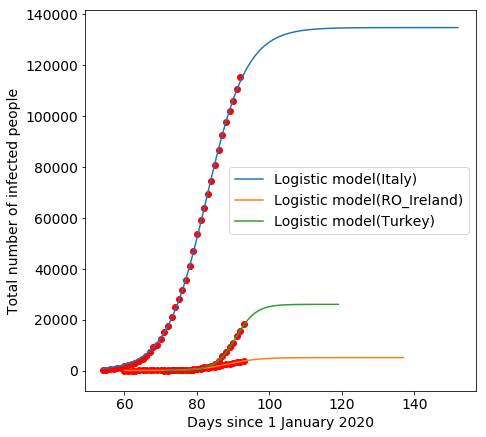

In [46]:
plot_curves_countries(logistic_model, country_2_abc_tuple_lr, country_2_xy)

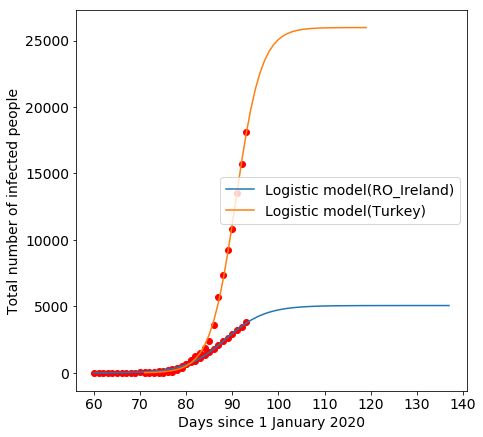

In [47]:
country_2_abc_tuple_lr.pop("Italy")
country_2_xy.pop("Italy")
plot_curves_countries(logistic_model, country_2_abc_tuple_lr, country_2_xy)